In [1]:
import os
import pandas as pd
import networkx as nx
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

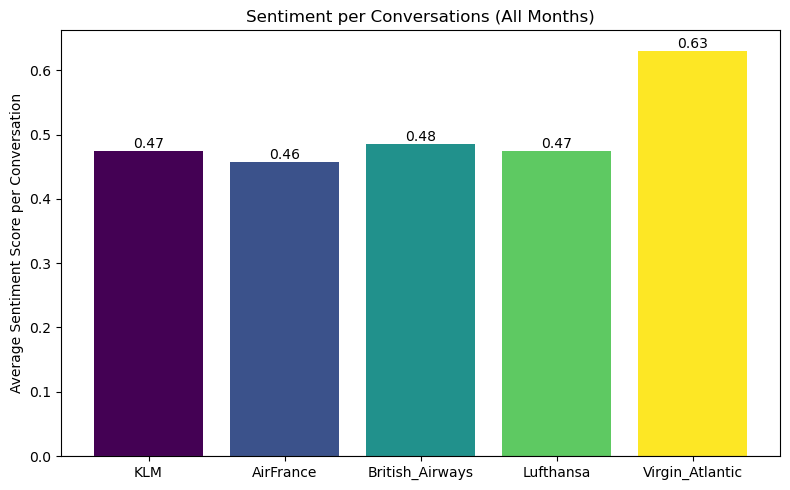

In [ ]:


month = "all"  #e.g. "October" or use "all" for no filters.
month = month.lower()

# Load the graph
try:

    script_dir = os.path.dirname(os.path.abspath(_file_))

    project_root = os.path.dirname(script_dir)
    print(f"Running as a script. Project root found at: {project_root}")
except NameError:

    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
    print(f"Running in an interactive environment. Assuming project root is: {project_root}")

# Define the path to the data file, relative to the project root
data_folder = os.path.join(project_root, "data")
graph_filename = "conversation_airlines_senti_correct.gpickle"
graph_path = os.path.join(data_folder, graph_filename)

# Now, use this robust path to load your file

print(f"\nLoading graph from: {graph_path}")

try:
    with open(graph_path, "rb") as f:
        G = pickle.load(f)
    print("Pickle load time (s):", time.time() - t0)
except FileNotFoundError:
    print(f"\n--- ERROR ---")
    print(f"File not found at the specified path: {graph_path}")
    print("Please check that the file exists and that the project structure is correct.")

airlines = {
    "KLM" : 124476322,
    "AirFrance": 106062176,
    "British_Airways": 18332190,
    "Lufthansa": 124476322,
    "Virgin_Atlantic": 20626359
}

avg_sentiments_per_airline = {}

for airline_name, airline_id in airlines.items():
    wccs = list(nx.weakly_connected_components(G))
    keep_sets = [
        comp for comp in wccs
        if any(G.nodes[n].get("user") == airline_id for n in comp)
    ]

    nodes_to_keep = set().union(*keep_sets)
    H = G.subgraph(nodes_to_keep).copy()

    branch_avg_sentiments = []

    for component in nx.weakly_connected_components(H):
        subgraph = H.subgraph(component)
        roots = [n for n in subgraph if subgraph.in_degree(n) == 0]
        leaves = [n for n in subgraph if subgraph.out_degree(n) == 0]

        for root in roots:
            paths = nx.single_source_shortest_path(subgraph, root)
            for leaf in leaves:
                if leaf in paths:
                    path = paths[leaf]

                    
                    node_months = []
                    for n in path:
                        created = H.nodes[n].get("created")
                        if created:
                            dt = pd.to_datetime(created)
                            node_months.append(dt.strftime("%B").lower())

                    if month != "all" and month not in node_months:
                        continue

                    
                    sentiment_scores = [
                        H.nodes[n].get("sentiment_score")
                        for n in path
                        if H.nodes[n].get("sentiment_score") is not None
                    ]
                    if sentiment_scores:
                        avg_sent = sum(sentiment_scores) / len(sentiment_scores)
                        branch_avg_sentiments.append(avg_sent)

    if branch_avg_sentiments:
        avg_sentiment = sum(branch_avg_sentiments) / len(branch_avg_sentiments)
    else:
        avg_sentiment = 0  
    avg_sentiments_per_airline[airline_name] = avg_sentiment

plt.figure(figsize=(8, 5))
airline_names = list(avg_sentiments_per_airline.keys())
sentiment_scores = list(avg_sentiments_per_airline.values())

bars = plt.bar(airline_names, sentiment_scores, color=plt.cm.viridis(np.linspace(0, 1, len(airline_names))))
plt.axhline(0, color='gray', linewidth=0.8)
plt.ylabel("Average Sentiment Score per Conversation")
plt.title(f"Sentiment per Conversations ({month.title() if month != 'all' else 'All Months'})")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
#plt.savefig(r"", dpi=300, bbox_inches="tight", transparent=True)
plt.show()